In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook


### Run methods

HB: stepsize= 0.190983005625  Momentum= 0.14589803375
101


/home/jonas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


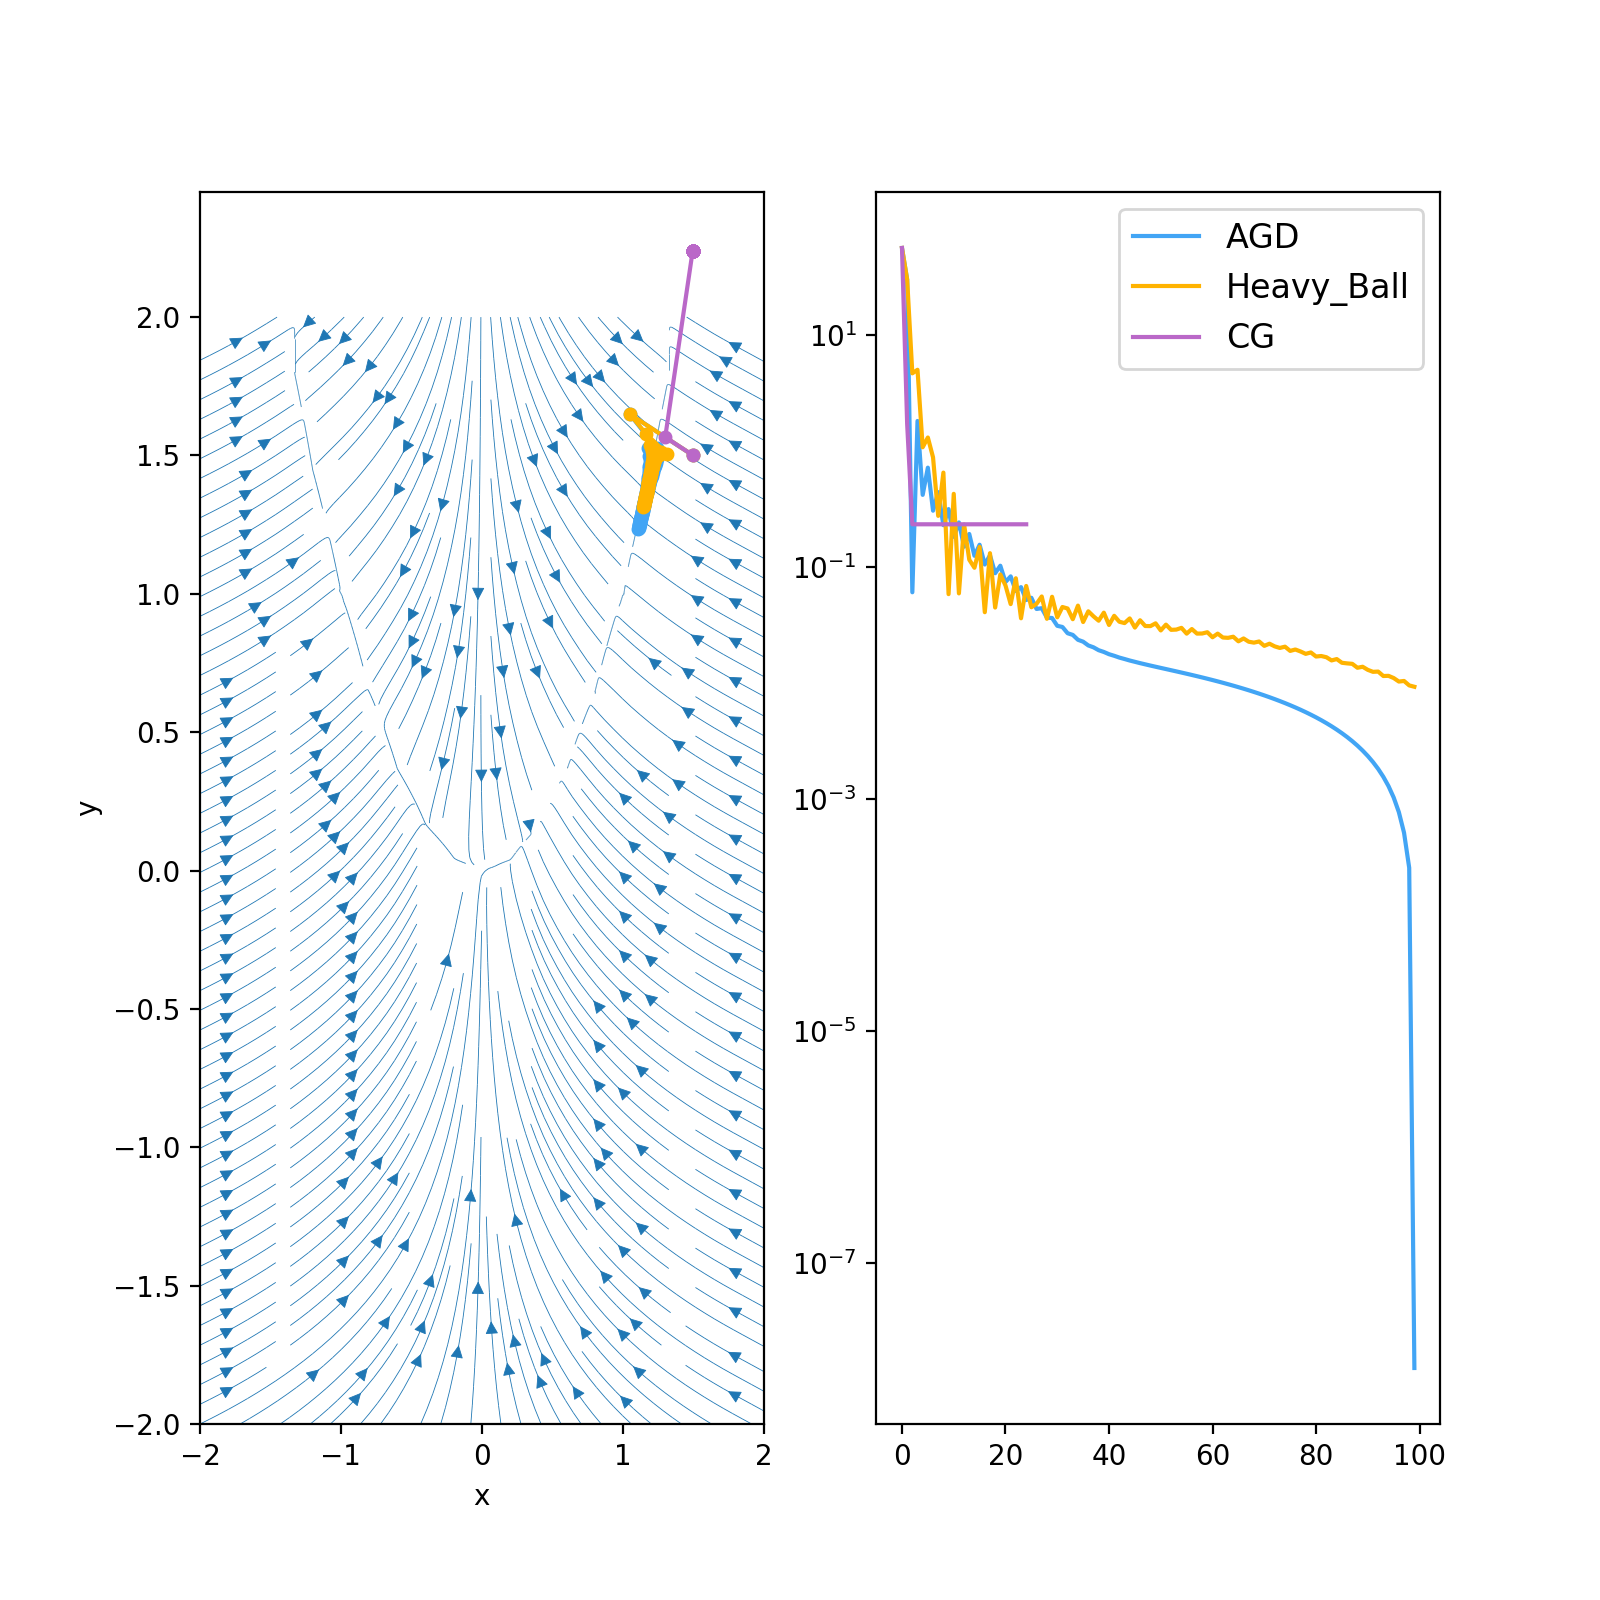

<IPython.core.display.Javascript object>


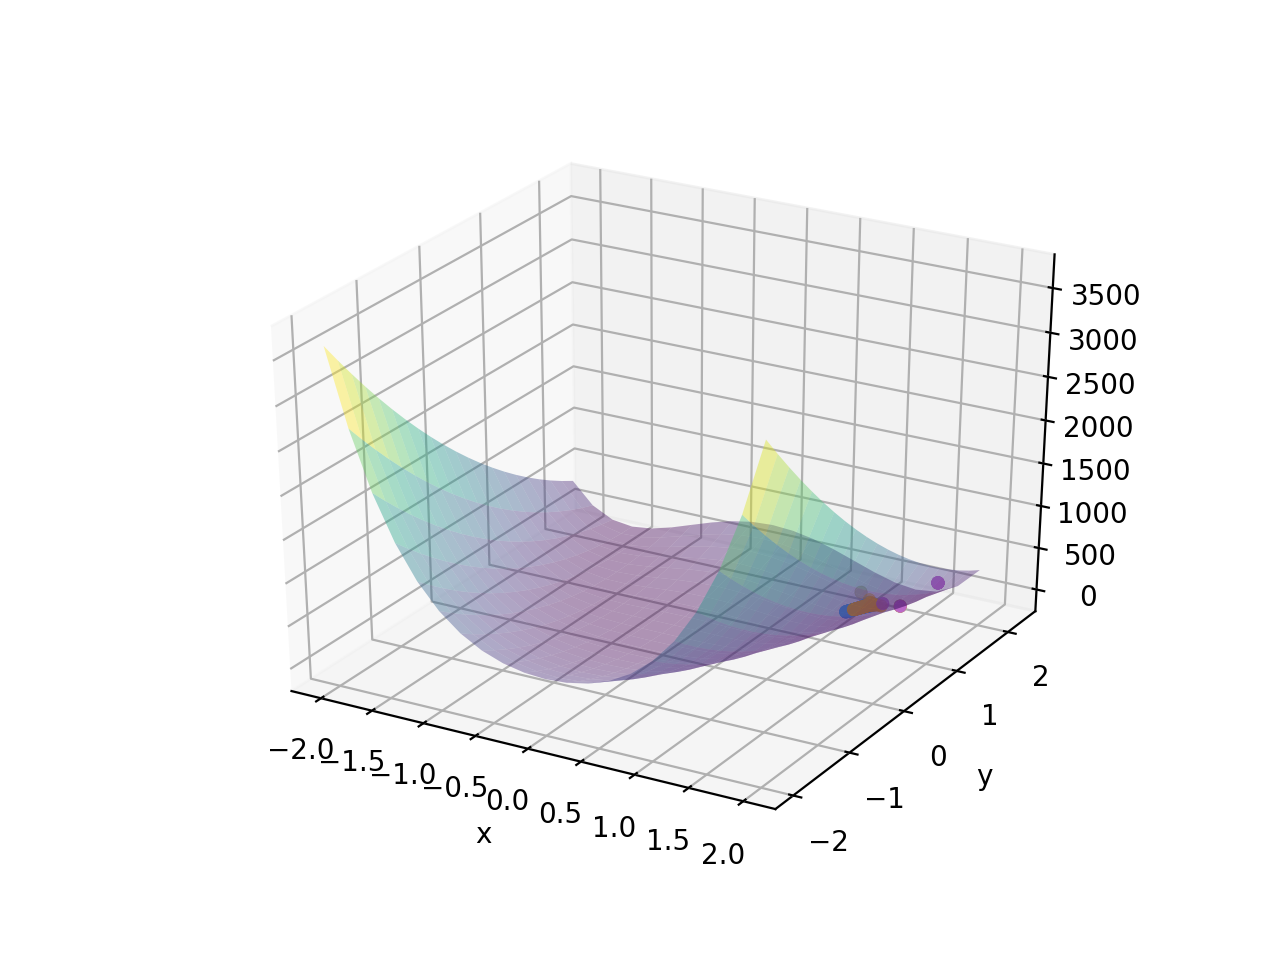

In [63]:
no_of_runs=1
iterations=100
accuracy=1e-10
step_size=1/10  #1/L for the quadratics

#HB step and momentum for Non-Convex
lipschitz=10
momentum=0.2
step_size_HB=2*(1-momentum)/lipschitz-0.001

#HB step and momentum for strongly Convex
lambda_min=2
condition_number=lipschitz/lambda_min
step_size_HB=4/((np.sqrt(lipschitz)+np.sqrt(lambda_min))**2)
momentum=((np.sqrt(condition_number)-1)/(np.sqrt(condition_number)+1))**2
print('HB: stepsize=',step_size_HB, ' Momentum=',momentum )
### this should give better convergence than AGD and GD!!


global loss_type
global log_loss
log_loss=True
#loss_type='coercive_saddle'
loss_type='tube'
loss_type='rosenbrock'
list_loss = []
list_x = []
list_methods = []
list_steps = []
#plot limits
limits=np.array((-2,2))

GD=False
AGD=True
HB=True
CG=True


x_0=1.5
y_0=1.5
w_0=np.array((x_0,y_0))

if GD:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD_steps,_x,_loss)= Gradient_Descent(w_0,iterations,step_size,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD_loss)
    list_x.append(GD_x)
    list_methods.append('GD_loc')
    list_steps.append(GD_steps)
    
    
if GD:
    if loss_type=='coercive_saddle':
        w_0=np.array((x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (GD2_steps,_x,_loss)= Gradient_Descent(w_0,iterations,1/6,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    GD2_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    GD2_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(GD2_loss)
    list_x.append(GD2_x)
    list_methods.append('GD_glob')
    list_steps.append(GD2_steps)
 
if AGD:
    if loss_type=='coercive_saddle':
        w_0=np.array((-x_0,y_0))

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (AGD_steps,_x,_loss)= Accelerated_Gradient_Descent(w_0,iterations,1/1000,accuracy)
        loss_collector.append(_loss)
        x_collector.append(_x)
    AGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    AGD_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(AGD_loss)
    list_x.append(AGD_x)
    list_methods.append('AGD')
    list_steps.append(AGD_steps)

if HB:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (Heavy_Ball_steps,_x,_loss,momentum_magnitudes)= Heavy_Ball(w_0,iterations,1/1000,accuracy,momentum)
        loss_collector.append(_loss)
        x_collector.append(_x)
    Heavy_Ball_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    Heavy_Ball_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(Heavy_Ball_loss)
    list_x.append(Heavy_Ball_x)
    list_methods.append('Heavy_Ball')
    list_steps.append(Heavy_Ball_steps)
if CG:

    loss_collector=[]
    x_collector=[]
    for k in range(no_of_runs):
        (CG_steps,_x,_loss)= Conjugate_Gradients(w_0,iterations)
        loss_collector.append(_loss)
        x_collector.append(_x)
    CG_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    CG_x =[float(sum(col))/len(col) for col in zip(*x_collector)]   
    
    list_loss.append(CG_loss)
    list_x.append(CG_x)
    list_methods.append('CG')
    list_steps.append(CG_steps)
       
    
make_plot(list_loss,list_x,list_methods,list_steps,limits)


### some necessary functions:

In [20]:
 def compute_loss(w):
    if loss_type=='coercive_saddle':
        loss=0.5*w[0]**2+1/4*w[1]**4-0.5*w[1]**2
    elif loss_type=='quadratic':
        loss=w[0]**2+5*w[1]**2
    elif loss_type=='tube':
        L=1.5
        gamma=1
        if 0<=w[0]<=1 and 0<=w[1]<=1:
            loss=-gamma*w[0]**2+L*w[1]**2
        elif 1<=w[0]<=3 and 0<=w[1]<=1:
            loss=L*(w[0]-2)**2-gamma*w[1]**2
        elif 1<=w[0]<=3 and 1<=w[1]<=3:
            loss=L*(w[0]-2)**2+L*(w[1]-2)**2
        else:
            loss=0
    elif loss_type=='rosenbrock':
            loss = (1. - w[0]) ** 2 + 100. * (w[1] - w[0] ** 2) ** 2
            
    else:
        raise ValueError("Unknown losstype!")
    
    return loss

def compute_gradients(w):
# forward pass

    if loss_type=='coercive_saddle':
        grad = np.array([w[0], w[1] ** 3 - w[1]])
    elif loss_type=='quadratic':
        grad = np.array([2*w[0],10*w[1]])

    elif loss_type=='tube':
        L=1.5
        gamma=1
        if 0<=w[0]<=1 and 0<=w[1]<=1:
            grad = np.array([-2*gamma*w[0], 2*L* w[1]])
        elif 1<=w[0]<=3 and 0<=w[1]<=1:
            grad = np.array([2*L*(w[0]-2), -2*gamma* w[1]])
        elif 1<=w[0]<=3 and 1<=w[1]<=3:
            grad = np.array([2*L*(w[0]-2), 2*L*(w[1]-2)])
        else:
            grad=np.array([0,0])
    elif loss_type=='rosenbrock':
        grad = np.array([-2 + 2. * w[0] - 400 * w[0] * w[1] + 400 * w[0] ** 3, 200. * w[1] - 200 * w[0] ** 2])

    else:
        raise ValueError("Unknown losstype!")
        
    return grad

def compute_hessian(w):
    if loss_type == 'rosenbrock':
        H = np.array([[2 - 400 * w[1] + 1200 * w[0] ** 2, -400 * w[0]], [-400 * w[0], 200]])
    elif loss_type== 'quadratic':
        H= 2* np.array([[1,0],[0,5]])
        
    return H


def make_plot(list_loss,list_x,list_methods,list_steps,limits):
    colors = ['#42A5F5', '#FFB300', '#BA68C8','#7CB342']
    if log_loss:
        #overall min value
        min_value=1000
        for k in range(len(list_loss)):
            min_value = min(list_loss[k]) if (min(list_loss[k])<=min_value) else min_value
        #subtract min value from all values and add epsilon
        eps = min_value*1e-6
        for k in range(len(list_loss)):
            list_loss[k]= [i - min_value+eps  for i in list_loss[k]]

    s=0.2
    x_ax = np.arange(limits[0],limits[1]+s, s)  
    y_ax = np.arange(limits[0],limits[1]+s, s)  
    x_ax,y_ax = np.meshgrid(x_ax,y_ax)
    gradient_x=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_y=np.zeros((y_ax.shape[0],y_ax.shape[1]))
    loss=np.zeros((x_ax.shape[0],x_ax.shape[1]))

    for i in range(x_ax.shape[0]):
        for j in range(x_ax.shape[1]):
            grad=compute_gradients(np.array((x_ax[i,j],y_ax[i,j])))
            gradient_x[i,j]=grad[0]
            gradient_y[i,j]=grad[1]
            loss[i,j]=compute_loss(np.array((x_ax[i,j],y_ax[i,j])))


    #1. Plot Gradient Flow
    plt.subplot(1, 2, 1)
        
    plt.streamplot(x_ax,y_ax,-gradient_x,-gradient_y, density=2, linewidth='0.3')
    plt.gcf().set_size_inches((8,8))
    plt.show()
    plt.xlabel('x')
    plt.ylabel('y')
    
    #Show iterates
    for i in range (len(list_loss)):
        plt.plot(np.array(list_steps[i])[:,0],np.array(list_steps[i])[:,1], '-o',color= colors[i],markersize='4',alpha=1)
    #plt.legend(list_methods,fontsize=12, loc=1)

    #2. Plot performance over time/steps
    plt.subplot(1, 2, 2)
    for i in range(len(list_loss)):
        plt.plot(list_x[i], list_loss[i],color= colors[i])
    plt.legend(list_methods,fontsize=12, loc=1)
    
    if log_loss:
        plt.yscale('log')
    else: 
        plt.yscale('linear')
    
    #3 .Plot Error Surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_ax, y_ax, loss,cmap='viridis', 
                    alpha=0.4,zorder=1)  
    # Show iterates
    for i in range(len(list_loss)):
        ax.scatter(np.array(list_steps[i])[:,0],np.array(list_steps[i])[:,1], list_loss[i],'o',color= colors[i],linewidth='0.25',zorder=i+2)

    plt.xlabel('x')
    plt.ylabel('y')



### Gradient Descent

In [60]:
# Run GD (simultaneously)
def Gradient_Descent(w,iterations,step_size,accuracy):
    iterates=[]
    loss=[]
    x=[]
    for k in range(iterations): 
        #safe information
        iterates.append(w)
        x.append(k)
        loss.append(compute_loss(w))
        
        #take step
        grad=compute_gradients(w)  
        w=w-step_size*grad
    

    return(iterates,x,loss)

def Conjugate_Gradients(w,iterations):
    iterates=[]
    loss=[]
    x=[]
    
    H=compute_hessian(w)  
    grad=compute_gradients(w)  
    g=grad
    p=-g
    for k in range(iterations):
        iterates.append(w)
        x.append(k)
        loss.append(compute_loss(w))
        
        Hp=np.dot(H, p)
        pHp=np.dot(p,Hp)
        alpha = np.dot(g, g) / pHp
        w= w + alpha*p
        g_next=g+alpha*Hp
        beta= np.dot(g_next, g_next) / np.dot(g, g)
        g=g_next
        p=-g_next+beta*p

    return(iterates,x,loss)


### Accelerated Gradient Descent

In [57]:
#Run AGD
def Accelerated_Gradient_Descent(w,iterations,step_size, accuracy):
    iterates=[]
    loss=[]
    x=[]
    w_old=w
    print(iterations+1)


    for k in range(1,iterations+1): 

        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        if loss_type=='quadratic':
            beta_k=(np.sqrt(10/2)-1)/(np.sqrt(10/2)+1)
        else:
            beta_k=(k-1)/(k+2)
        y=w+beta_k*(w-w_old)
        if loss_type=='tube':
            if y[1]<0:
                y[1]=-y[1]
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(y)
        w=y-step_size*grad
        if loss_type=='tube':
            if w[1]<0:
                w[1]=-w[1]
 

    return(iterates,x,loss)

#Run Momentum
def Heavy_Ball(w,iterations,step_size, accuracy,momentum):
    iterates=[]
    loss=[]
    momentum_magnitudes=[]
    x=[]
    w_old=w

    for k in range(1,iterations+1): 
        iterates.append(w)
        x.append(k-1)
        loss.append(compute_loss(w))
        
        #compute y_(k)
        y=w+(k-1)/(k+2)*(w-w_old)
        #y=w+momentum*(w-w_old)
        momentum_magnitudes.append(np.abs(w-w_old))
        #store x_(k-1)
        w_old=w
        #compute gradients
        grad=compute_gradients(w)
        w=y-step_size*grad
 
    return(iterates,x,loss, momentum_magnitudes)